In [1]:
from pyspi.utils.data_builder.time_series_builder import TimeSeriesBuilderSPI
import numpy as np
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets

grb_time = "120711 024453"
ebounds = np.geomspace(20,80,40)
ein = np.geomspace(10,3000,50)
t1 = 35000
t2 = 38000
version = find_response_version(grb_time)
rsp_base = ResponseDataRMF.from_version(version)
dets = get_live_dets(time=grb_time, event_types=["single"])

16:37:36 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=700636;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=542852;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=676382;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=578927;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=583286;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=897763;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=190143;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=867623;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=2716;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=587393;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=141691;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=232377;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=24192;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=315536;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=912475;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=480333;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=158181;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=92819;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

/home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


16:37:36 INFO      Starting 3ML!                                                                     ]8;id=992522;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=494277;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=93410;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=417115;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=769369;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=767354;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=177171;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=828293;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=459898;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=749735;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#46\46]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=633764;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=768001;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=465513;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=19491;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

16:37:37 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=408039;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=426263;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=254998;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=715634;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=238443;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=702506;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

16:37:37 WARNING   No fermitools installed                                              ]8;id=7819;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=232425;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=367808;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=142241;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=470570;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=565124;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=22317;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=24388;file:///home/moej56153/.pyenv/versions/3.9.13/envs/MT2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)


In [2]:
tsbs = []
sds1 = []
sds2 = []
ra1, dec1 = 94.67830, -70.99905
ra2, dec2 = 92.67830, -70.99905
for d in dets:
    tsb = TimeSeriesBuilderSPI.from_spi_grb(f"SPIDet{d}", 
                                        d, 
                                        #ebounds_sgl, 
                                        grb_time, 
                                        ebounds=ebounds,
                                        sgl_type="both",
                                        poly_order=-1,
                                        )
    rsp = ResponseRMFGenerator.from_time(grb_time,  d,
                                            ebounds, ein,
                                            rsp_base)
    sd1 = SPIDRM(rsp, ra1, dec1)
    sd2 = SPIDRM(rsp.clone(), ra2, dec2)
    tsbs.append(tsb)
    sds1.append(sd1)
    sds2.append(sd2)

AFS data access did not work. I will try the ISDC data archive.
receiving incremental file list
spi_gti.fits.gz

sent 44 bytes  received 3,828 bytes  7,744.00 bytes/sec
total size is 3,720  speedup is 0.96



WARNING NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.



In [3]:
bkgs=np.array([])
for tsb in tsbs:
    bkgs = np.append(bkgs, tsb.time_series.count_per_channel_over_interval(-1000,0)/tsb.time_series.exposure_over_interval(-1000,0))
bkgs=bkgs.reshape((len(dets), -1));

In [4]:
# source model
from astromodels import Powerlaw, Log_uniform_prior, Uniform_prior, PointSource, SpectralComponent
import numpy as np
pl = Powerlaw()
pl.index = -2.08
pl.K = 6.44*10**-4
pl.piv = 100

pl.K.prior = Log_uniform_prior(lower_bound=1e-8, upper_bound=1e0)
pl.index.prior = Uniform_prior(lower_bound=-4, upper_bound=0)

component1 = SpectralComponent('pl',shape=pl)
ps = PointSource('plline',ra=94.67830, dec=-70.99905, components=[component1])

spec = ps(ein)

spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2

In [5]:
# model counts
model_count_rates1 = np.array([])#np.dot(spec_binned, sd_sgl1.matrix.T)
model_count_rates2 = np.array([])#np.dot(spec_binned, sd_sgl2.matrix.T)
for sd1, sd2 in zip(sds1, sds2):
    model_count_rates1 = np.append(model_count_rates1, np.dot(spec_binned, sd1.matrix.T))
    model_count_rates2 = np.append(model_count_rates2, np.dot(spec_binned, sd2.matrix.T))
model_count_rates1 = model_count_rates1.reshape((len(dets), -1));
model_count_rates2 = model_count_rates2.reshape((len(dets), -1));

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()
i=0
for d in range(19):
    axes[d].text(.5,.9,f"Det {d}",horizontalalignment='center',transform=axes[d].transAxes)
    if d in dets:
        if i==0:
            axes[d].step(ebounds[:-1], bkgs[i], label="background")
            axes[d].step(ebounds[:-1], model_count_rates1[i], label="model1")
            axes[d].step(ebounds[:-1], model_count_rates2[i], label="model2")
        else:
            axes[d].step(ebounds[:-1], bkgs[i])
            axes[d].step(ebounds[:-1], model_count_rates1[i])
            axes[d].step(ebounds[:-1], model_count_rates2[i])
        i+=1
    axes[d].set_yscale("log")
    axes[d].set_ylim(10**-3, 20)
for i in range(16,20):
    axes[i].set_xlabel("Detected Energy [keV]")
for i in range(0,20,4):
    axes[i].set_ylabel("Count Rates [1/s]")
plt.subplots_adjust(hspace=0, wspace=0)
plt.subplots_adjust(hspace=0, top=0.96, bottom=0.1)
lgd = fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize='x-large')
# fig.savefig("bkg_models.pdf")


In [7]:
data1 = np.array([])
data2 = np.array([])
for bkg, m1, m2 in zip(bkgs, model_count_rates1, model_count_rates2):
    data1 = np.append(data1, np.random.poisson(t1*(bkg+m1)))
    data2 = np.append(data2, np.random.poisson(t2*(bkg+m2)))
    
data1 = data1.reshape((len(dets), -1));
data2 = data2.reshape((len(dets), -1));

In [8]:
import math
from numba import njit

@njit
def bmaxba(m1, m2, t1, t2, C1, C2):
    first = C1+C2-(m1+m2)*(t1+t2)
    root = (C1+C2+(m1-m2)*(t1+t2))**2-4*C1*(m1-m2)*(t1+t2)
    res = (first+np.sqrt(root))/(2*(t1+t2))
    return res
matrices1 = np.array([])
sd_x, sd_y = sds1[0].matrix.T.shape
for sd in sds1:
    matrices1=np.append(matrices1,sd.matrix.T)
matrices1=matrices1.reshape((len(dets), sd_x, sd_y))

matrices2 = np.array([])
for sd in sds2:
    matrices2=np.append(matrices2,sd.matrix.T)
matrices2=matrices2.reshape((len(dets), sd_x, sd_y))

@njit
def logLcore(spec_binned):
    logL=0
    for j in range(len(dets)):
        m1 = np.dot(spec_binned, matrices1[j])
        m2 = np.dot(spec_binned, matrices2[j])
        for i in range(len(m1)):
            bm = bmaxba(m1[i], m2[i], t1, t2, data1[j, i], data2[j, i])
            logL += (data1[j,i]*math.log(t1*(m1[i]+bm))+
                    data2[j,i]*math.log(t2*(m2[i]+bm))-
                    t1*(m1[i]+bm)-
                    t2*(m2[i]+bm))
    return logL

def logLba_mult(trial_values, ndim=None, params=None):
    pl.index = trial_values[1]
    pl.K = trial_values[0]
    spec = pl(ein)
    spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2
    return logLcore(spec_binned)

In [9]:
def prior(params, ndim=None, nparams=None):
    for i, (parameter_name, parameter) in enumerate(
        ps.free_parameters.items()
    ):

        try:

            params[i] = parameter.prior.from_unit_cube(params[i])

        except AttributeError:

            raise RuntimeError(
                "The prior you are trying to use for parameter %s is "
                "not compatible with sampling from a unitcube"
                % parameter_name
            )

In [10]:
import pymultinest
import os
if not os.path.exists("./chains"):
    os.mkdir("chains")
sampler = pymultinest.run(
                    logLba_mult, prior, 2, 2, n_live_points=800, resume=False, verbose=True
                )

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999412
Acceptance Rate:                        0.991189
Replacements:                                900
Total Samples:                               908
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999449
Acceptance Rate:                        0.984456
Replacements:                                950
Total Samples:                               965
Nested Sampling

In [11]:
%matplotlib inline
from chainconsumer import ChainConsumer
import numpy as np


def loadtxt2d(intext):
        try:
            return np.loadtxt(intext, ndmin=2)
        except:
            return np.loadtxt(intext)

c = ChainConsumer()

chain = loadtxt2d('./chains/1-post_equal_weights.dat')

#c.add_chain(chain, parameters=['K', 'index', 'F', 'mu','sigma', '$z$'], name='yeah')
c.add_chain(chain, parameters=['K', 'index', '$z$'], name='fit')

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

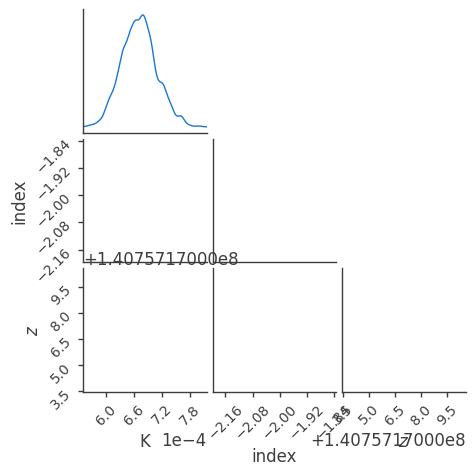

In [14]:
# c.plotter.plot(filename="fit_corner.pdf", 
#                 parameters=['K', 'index'],
#                 # truth=[6.44*10**-4, -2.08],
#                 log_scales=[]);

c.plotter.plot()